## Setup

### Initialization

In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import isoweek
import math

import unittest

In [68]:
path = 'EURUSD-2024.csv'

year = 2025
file = pd.read_csv(path,
                   sep=';',
                   header=None,
                   usecols=[0, 1, 2, 3, 4],
                   names=['time', 'open', 'high', 'low', 'close'],
                   parse_dates=[0],
                   date_format='%Y%m%d %H%M%S'
                   )

### Data Cleaning

In [69]:
count = 0
high = 0.00000
low = 9.99999
open_price = 0.00000
close_price = 0.00000

# section = file.loc[:29]
clean = pd.DataFrame(columns=['week', 'day', 'hour', 'minute',
                              'open', 'high', 'low', 'close',
                              'momentum', 'avg', 'range', 'ohlc'])

for row in file.itertuples():
    if (row[3] > high):
        high = row[3]
    
    if (row[4] < low):
        low = row[4]

    if (count == 0):
        minute = row[1].minute
        open_price = row[2]

    if (count == 9):
        close_price = row[5]
        hour = row[1].hour
        day = row[1].weekday()
        week = row[1].week
        momentum = open_price - close_price
        avg = ( (low + high) / 2 )
        price_range = high - low
        ohlc = ( (open_price + high + low + close_price) / 4)
        
        new_row = [week, day, hour, minute,
                   open_price, high, low, close_price,
                   momentum, avg, price_range, ohlc]
        clean.loc[len(clean)] = new_row
        
        count = 0
        high = 0
        low = 999
        continue
    
    count += 1

### Normalization

In [70]:
split = int( (0.8*len(clean)) )
train = clean[:split]
test = clean[split:]

In [71]:
def to_normal_vector(value):
    angle = value * math.pi * 2
    x = math.sin(angle)
    y = math.cos(angle)
    x = (x + 1) / 2
    y = (y + 1) / 2
    return(x, y)

In [72]:
def normalize_time(df):
    time = pd.DataFrame(columns=['week_x', 'week_y', 'day_x', 'day_y',
                                 'hour_x', 'hour_y', 'minute_x', 'minute_y'])

    for row in df.itertuples():
        week_ratio = row[1] / isoweek.Week.last_week_of_year(year).week
        week = to_normal_vector(week_ratio)
        day_ratio = row[2] / 7
        day = to_normal_vector(day_ratio)
        hour_ratio = row[3] / 24
        hour = to_normal_vector(hour_ratio)
        minute_ratio = row[4] / 6
        minute = to_normal_vector(minute_ratio)
    
        new_row = [ week[0], week[1], day[0], day[1],
                    hour[0], hour[1], minute[0], minute[1] ]
        time.loc[len(time)] = new_row

    return time

In [73]:
time = normalize_time(train)
test_time = normalize_time(test)

In [74]:
price_columns = ['open', 'high', 'low', 'close',
                'momentum', 'avg', 'range', 'ohlc']
prices = train[price_columns]
scaler = MinMaxScaler()
scaler.set_output(transform='pandas')
prices = scaler.fit_transform(prices)

In [75]:
test_prices = test[price_columns]
test_prices = scaler.transform(test_prices)
test_prices.reset_index(inplace=True, drop=True)

In [76]:
norm_test = pd.concat([test_time, test_prices], axis=1)
norm_train = pd.concat([test_time, test_prices], axis=1)

### Sequencing

In [77]:
# https://www.geeksforgeeks.org/deep-learning/time-series-forecasting-using-tensorflow/

def create_sequences(data, seq_length=5):
    input_data, target = [], []
    for i in range(len(data) - seq_length):
        input_data.append(data.iloc[i:i+seq_length])
        target.append(data.iloc[i+seq_length])
    return np.array(input_data), np.array(target)

# https://www.geeksforgeeks.org/deep-learning/time-series-forecasting-using-tensorflow/

In [78]:
# step = 50 # predict the 60th minute from 50
x_train, y_train = create_sequences(norm_train)
x__test, y_test = create_sequences(norm_test)

## Data Loading and Cleaning

In [79]:
path = 'EURUSD-Jul25.csv'

year = 2025
file = pd.read_csv(path,
                   sep=';',
                   header=None,
                   usecols=[0, 1, 2, 3, 4],
                   names=['time', 'open', 'high', 'low', 'close'],
                   parse_dates=[0],
                   date_format='%Y%m%d %H%M%S'
                   )

In [80]:
print(file.head())

                 time     open     high      low    close
0 2025-07-01 00:00:00  1.17894  1.17902  1.17891  1.17902
1 2025-07-01 00:01:00  1.17899  1.17902  1.17893  1.17893
2 2025-07-01 00:02:00  1.17892  1.17894  1.17884  1.17886
3 2025-07-01 00:03:00  1.17885  1.17892  1.17879  1.17891
4 2025-07-01 00:04:00  1.17890  1.17893  1.17881  1.17883


In [81]:
print(file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33039 entries, 0 to 33038
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    33039 non-null  datetime64[ns]
 1   open    33039 non-null  float64       
 2   high    33039 non-null  float64       
 3   low     33039 non-null  float64       
 4   close   33039 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.3 MB
None


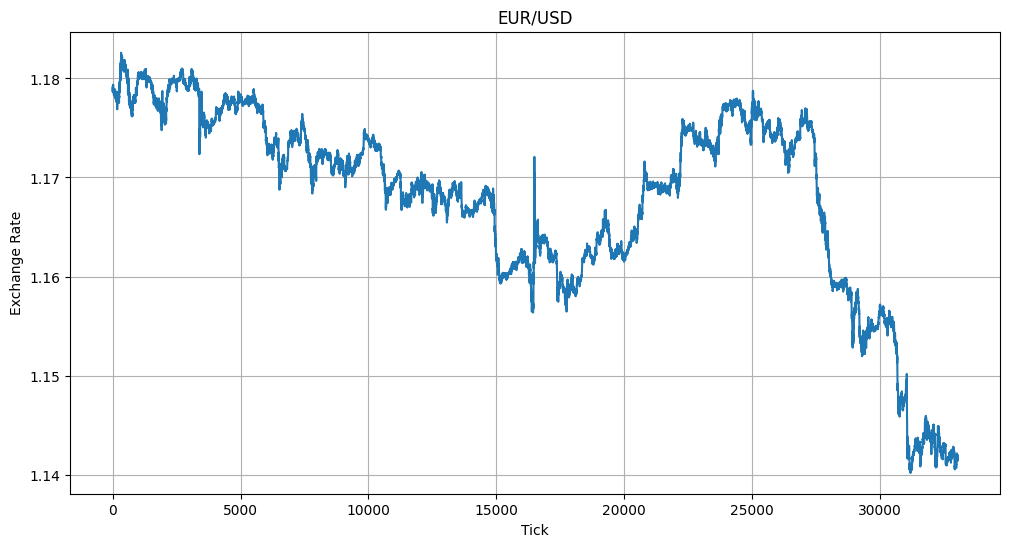

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(file.index, file['close'])
plt.title('EUR/USD')
plt.xlabel('Tick')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [83]:
count = 0
high = 0.00000
low = 9.99999
open_price = 0.00000
close_price = 0.00000

# section = file.loc[:29]
clean = pd.DataFrame(columns=['week', 'day', 'hour', 'minute',
                              'open', 'high', 'low', 'close',
                              'momentum', 'avg', 'range', 'ohlc'])

for row in file.itertuples():
    if (row[3] > high):
        high = row[3]
    
    if (row[4] < low):
        low = row[4]

    if (count == 0):
        minute = row[1].minute
        open_price = row[2]

    if (count == 9):
        close_price = row[5]
        hour = row[1].hour
        day = row[1].weekday()
        week = row[1].week
        momentum = open_price = close_price
        avg = ( (low + high) / 2 )
        price_range = high - low
        ohlc = ( (open_price + high + low + close_price) / 4)
        
        new_row = [week, day, hour, minute,
                   open_price, high, low, close_price,
                   momentum, avg, price_range, ohlc]
        clean.loc[len(clean)] = new_row
        
        count = 0
        high = 0
        low = 999
        continue
    
    count += 1

In [84]:
print(clean.head(10))

   week  day  hour  minute     open     high      low    close  momentum  \
0  27.0  1.0   0.0     0.0  1.17891  1.17902  1.17858  1.17891   1.17891   
1  27.0  1.0   0.0    10.0  1.17925  1.17930  1.17891  1.17925   1.17925   
2  27.0  1.0   0.0    20.0  1.17904  1.17937  1.17900  1.17904   1.17904   
3  27.0  1.0   0.0    30.0  1.17872  1.17904  1.17869  1.17872   1.17872   
4  27.0  1.0   0.0    40.0  1.17866  1.17880  1.17844  1.17866   1.17866   
5  27.0  1.0   0.0    50.0  1.17862  1.17865  1.17826  1.17862   1.17862   
6  27.0  1.0   1.0     0.0  1.17856  1.17877  1.17848  1.17856   1.17856   
7  27.0  1.0   1.0    10.0  1.17828  1.17869  1.17823  1.17828   1.17828   
8  27.0  1.0   1.0    20.0  1.17871  1.17878  1.17825  1.17871   1.17871   
9  27.0  1.0   1.0    30.0  1.17863  1.17894  1.17862  1.17863   1.17863   

        avg    range      ohlc  
0  1.178800  0.00044  1.178855  
1  1.179105  0.00039  1.179177  
2  1.179185  0.00037  1.179113  
3  1.178865  0.00035  1.178792 

In [85]:
print(clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3303 entries, 0 to 3302
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   week      3303 non-null   float64
 1   day       3303 non-null   float64
 2   hour      3303 non-null   float64
 3   minute    3303 non-null   float64
 4   open      3303 non-null   float64
 5   high      3303 non-null   float64
 6   low       3303 non-null   float64
 7   close     3303 non-null   float64
 8   momentum  3303 non-null   float64
 9   avg       3303 non-null   float64
 10  range     3303 non-null   float64
 11  ohlc      3303 non-null   float64
dtypes: float64(12)
memory usage: 335.5 KB
None


In [86]:
clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
week,3303.0,29.000303,1.351245,27.000000,28.000000,29.000000,30.000000,31.000000
day,3303.0,2.101726,1.558065,0.000000,1.000000,2.000000,3.000000,6.000000
hour,3303.0,11.482592,6.923891,0.000000,5.000000,11.000000,17.000000,23.000000
minute,3303.0,29.928853,17.328010,0.000000,15.000000,30.000000,45.500000,59.000000
open,3303.0,1.167841,0.009616,1.140280,1.162265,1.169670,1.175010,1.182310
high,3303.0,1.168131,0.009593,1.140520,1.162490,1.170050,1.175310,1.182980
low,3303.0,1.167559,0.009634,1.140080,1.162020,1.169330,1.174760,1.181850
close,3303.0,1.167841,0.009616,1.140280,1.162265,1.169670,1.175010,1.182310
momentum,3303.0,1.167841,0.009616,1.140280,1.162265,1.169670,1.175010,1.182310
avg,3303.0,1.167845,0.009611,1.140375,1.162245,1.169735,1.175028,1.182200


In [87]:
print(clean.index)

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302],
      dtype='int64', length=3303)


## Normalization

In [88]:
split = int( (0.8*len(clean)) )
train = clean[:split]
test = clean[split:]

In [89]:
def to_normal_vector(value):
    angle = value * math.pi * 2
    x = math.sin(angle)
    y = math.cos(angle)
    x = (x + 1) / 2
    y = (y + 1) / 2
    return(x, y)

In [90]:
for row in clean.itertuples():
    print(row)
    break

Pandas(Index=0, week=27.0, day=1.0, hour=0.0, minute=0.0, open=1.17891, high=1.17902, low=1.17858, close=1.17891, momentum=1.17891, avg=1.1787999999999998, range=0.00043999999999999595, ohlc=1.178855)


In [91]:
def normalize_time(df):
    time = pd.DataFrame(columns=['week_x', 'week_y', 'day_x', 'day_y',
                                 'hour_x', 'hour_y', 'minute_x', 'minute_y'])

    for row in df.itertuples():
        week_ratio = row[1] / isoweek.Week.last_week_of_year(year).week
        week = to_normal_vector(week_ratio)
        day_ratio = row[2] / 7
        day = to_normal_vector(day_ratio)
        hour_ratio = row[3] / 24
        hour = to_normal_vector(hour_ratio)
        minute_ratio = row[4] / 6
        minute = to_normal_vector(minute_ratio)
    
        new_row = [ week[0], week[1], day[0], day[1],
                    hour[0], hour[1], minute[0], minute[1] ]
        time.loc[len(time)] = new_row

    return time

In [92]:
time = normalize_time(train)
print(time)

        week_x    week_y     day_x     day_y    hour_x    hour_y  minute_x  \
0     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.500000   
1     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.066987   
2     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.933013   
3     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.500000   
4     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.066987   
...        ...       ...       ...       ...       ...       ...       ...   
2637  0.267638  0.057272  0.283058  0.049516  0.933013  0.250000  0.500000   
2638  0.267638  0.057272  0.283058  0.049516  0.933013  0.250000  0.066987   
2639  0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.933013   
2640  0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.500000   
2641  0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.066987   

      minute_y  
0         1.00  
1         0.25  
2         0.

In [93]:
print(len(time))

2642


In [94]:
print(type(time))

<class 'pandas.core.frame.DataFrame'>


In [95]:
price_columns = ['open', 'high', 'low', 'close',
                'momentum', 'avg', 'range', 'ohlc']
prices = train[price_columns]
scaler = MinMaxScaler()
scaler.set_output(transform='pandas')
prices = scaler.fit_transform(prices)

In [96]:
print(prices)

          open      high       low     close  momentum       avg     range  \
0     0.867446  0.847281  0.875143  0.867446  0.867446  0.866510  0.050805   
1     0.880702  0.858079  0.887743  0.880702  0.880702  0.878484  0.044610   
2     0.872515  0.860779  0.891180  0.872515  0.872515  0.881625  0.042131   
3     0.860039  0.848052  0.879343  0.860039  0.860039  0.869062  0.039653   
4     0.857700  0.838797  0.869798  0.857700  0.857700  0.859442  0.040892   
...        ...       ...       ...       ...       ...       ...       ...   
2637  0.600390  0.585422  0.605956  0.600390  0.600390  0.594817  0.083024   
2638  0.589084  0.579637  0.591065  0.589084  0.589084  0.584217  0.112763   
2639  0.538012  0.580794  0.558228  0.538012  0.538012  0.567923  0.223048   
2640  0.587914  0.596606  0.565483  0.587914  0.587914  0.579702  0.250310   
2641  0.614425  0.615503  0.609393  0.614425  0.614425  0.611896  0.168525   

          ohlc  
0     0.867085  
1     0.879729  
2     0.8771

In [97]:
test_time = normalize_time(test)
print(test_time)

       week_x    week_y     day_x     day_y    hour_x    hour_y  minute_x  \
0    0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.933013   
1    0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.500000   
2    0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.066987   
3    0.267638  0.057272  0.283058  0.049516  0.750000  0.066987  0.933013   
4    0.267638  0.057272  0.283058  0.049516  0.750000  0.066987  0.500000   
..        ...       ...       ...       ...       ...       ...       ...   
656  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.500000   
657  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.066987   
658  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.933013   
659  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.500000   
660  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.066987   

     minute_y  
0        0.25  
1        1.00  
2        0.25  
3        0.

In [98]:
test_prices = test[price_columns]
test_prices = scaler.transform(test_prices)
test_prices.reset_index(inplace=True, drop=True)

In [99]:
print(test_prices)

         open      high       low     close  momentum       avg     range  \
0    0.582066  0.595449  0.599847  0.582066  0.582066  0.596781  0.135068   
1    0.562183  0.575781  0.567010  0.562183  0.562183  0.569886  0.178439   
2    0.597661  0.578481  0.581520  0.597661  0.597661  0.578720  0.140025   
3    0.622612  0.610490  0.610920  0.622612  0.622612  0.610130  0.147460   
4    0.630409  0.615118  0.642612  0.630409  0.630409  0.628779  0.059480   
..        ...       ...       ...       ...       ...       ...       ...   
656 -0.580117 -0.571924 -0.558992 -0.580117 -0.580117 -0.593247  0.144981   
657 -0.579337 -0.573081 -0.530355 -0.579337 -0.579337 -0.579113  0.048327   
658 -0.586745 -0.586965 -0.539901 -0.586745 -0.586745 -0.591088  0.034696   
659 -0.580897 -0.588508 -0.546392 -0.580897 -0.580897 -0.595210  0.050805   
660 -0.571540 -0.576552 -0.534173 -0.571540 -0.571540 -0.582843  0.049566   

         ohlc  
0    0.588904  
1    0.565477  
2    0.587728  
3    0.6159

In [100]:
norm_test = pd.concat([test_time, test_prices], axis=1)

In [101]:
print(norm_test)

       week_x    week_y     day_x     day_y    hour_x    hour_y  minute_x  \
0    0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.933013   
1    0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.500000   
2    0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.066987   
3    0.267638  0.057272  0.283058  0.049516  0.750000  0.066987  0.933013   
4    0.267638  0.057272  0.283058  0.049516  0.750000  0.066987  0.500000   
..        ...       ...       ...       ...       ...       ...       ...   
656  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.500000   
657  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.066987   
658  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.933013   
659  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.500000   
660  0.215968  0.088508  0.716942  0.049516  0.370590  0.982963  0.066987   

     minute_y      open      high       low     close  momentum       avg  

In [102]:
print(len(prices))

2642


In [103]:
print(type(prices))

<class 'pandas.core.frame.DataFrame'>


In [104]:
print(prices)

          open      high       low     close  momentum       avg     range  \
0     0.867446  0.847281  0.875143  0.867446  0.867446  0.866510  0.050805   
1     0.880702  0.858079  0.887743  0.880702  0.880702  0.878484  0.044610   
2     0.872515  0.860779  0.891180  0.872515  0.872515  0.881625  0.042131   
3     0.860039  0.848052  0.879343  0.860039  0.860039  0.869062  0.039653   
4     0.857700  0.838797  0.869798  0.857700  0.857700  0.859442  0.040892   
...        ...       ...       ...       ...       ...       ...       ...   
2637  0.600390  0.585422  0.605956  0.600390  0.600390  0.594817  0.083024   
2638  0.589084  0.579637  0.591065  0.589084  0.589084  0.584217  0.112763   
2639  0.538012  0.580794  0.558228  0.538012  0.538012  0.567923  0.223048   
2640  0.587914  0.596606  0.565483  0.587914  0.587914  0.579702  0.250310   
2641  0.614425  0.615503  0.609393  0.614425  0.614425  0.611896  0.168525   

          ohlc  
0     0.867085  
1     0.879729  
2     0.8771

In [105]:
norm_train = pd.concat([time, prices], axis=1)

In [106]:
print(norm_train)

        week_x    week_y     day_x     day_y    hour_x    hour_y  minute_x  \
0     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.500000   
1     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.066987   
2     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.933013   
3     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.500000   
4     0.439732  0.003646  0.890916  0.811745  0.500000  1.000000  0.066987   
...        ...       ...       ...       ...       ...       ...       ...   
2637  0.267638  0.057272  0.283058  0.049516  0.933013  0.250000  0.500000   
2638  0.267638  0.057272  0.283058  0.049516  0.933013  0.250000  0.066987   
2639  0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.933013   
2640  0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.500000   
2641  0.267638  0.057272  0.283058  0.049516  0.853553  0.146447  0.066987   

      minute_y      open      high       low     close  momentu

## Sequencing

In [107]:
norm_train.head(10)

,week_x,week_y,day_x,day_y,hour_x,hour_y,minute_x,minute_y,open,high,low,close,momentum,avg,range,ohlc
0,0.439732,0.003646,0.890916,0.811745,0.50000,1.000000,0.500000,1.00,0.867446,0.847281,0.875143,0.867446,0.867446,0.866510,0.050805,0.867085
1,0.439732,0.003646,0.890916,0.811745,0.50000,1.000000,0.066987,0.25,0.880702,0.858079,0.887743,0.880702,0.880702,0.878484,0.044610,0.879729
2,0.439732,0.003646,0.890916,0.811745,0.50000,1.000000,0.933013,0.25,0.872515,0.860779,0.891180,0.872515,0.872515,0.881625,0.042131,0.877181
3,0.439732,0.003646,0.890916,0.811745,0.50000,1.000000,0.500000,1.00,0.860039,0.848052,0.879343,0.860039,0.860039,0.869062,0.039653,0.864634
4,0.439732,0.003646,0.890916,0.811745,0.50000,1.000000,0.066987,0.25,0.857700,0.838797,0.869798,0.857700,0.857700,0.859442,0.040892,0.858655
5,0.439732,0.003646,0.890916,0.811745,0.50000,1.000000,0.933013,0.25,0.856140,0.833012,0.862925,0.856140,0.856140,0.852964,0.044610,0.854636
6,0.439732,0.003646,0.890916,0.811745,0.62941,0.982963,0.500000,1.00,0.853801,0.837640,0.871325,0.853801,0.853801,0.859639,0.032218,0.856793
7,0.439732,0.003646,0.890916,0.811745,0.62941,0.982963,0.066987,0.25,0.842885,0.834555,0.861779,0.842885,0.842885,0.853161,0.053284,0.848069
8,0.439732,0.003646,0.890916,0.811745,0.62941,0.982963,0.933013,0.25,0.859649,0.838025,0.862543,0.859649,0.859649,0.855320,0.061958,0.857577
9,0.439732,0.003646,0.890916,0.811745,0.62941,0.982963,0.500000,1.00,0.856530,0.844196,0.876670,0.856530,0.856530,0.865724,0.035936,0.861204


In [108]:
norm_test.head(10)

,week_x,week_y,day_x,day_y,hour_x,hour_y,minute_x,minute_y,open,high,low,close,momentum,avg,range,ohlc
0,0.267638,0.057272,0.283058,0.049516,0.853553,0.146447,0.933013,0.25,0.582066,0.595449,0.599847,0.582066,0.582066,0.596781,0.135068,0.588904
1,0.267638,0.057272,0.283058,0.049516,0.853553,0.146447,0.500000,1.00,0.562183,0.575781,0.567010,0.562183,0.562183,0.569886,0.178439,0.565477
2,0.267638,0.057272,0.283058,0.049516,0.853553,0.146447,0.066987,0.25,0.597661,0.578481,0.581520,0.597661,0.597661,0.578720,0.140025,0.587728
3,0.267638,0.057272,0.283058,0.049516,0.750000,0.066987,0.933013,0.25,0.622612,0.610490,0.610920,0.622612,0.622612,0.610130,0.147460,0.615958
4,0.267638,0.057272,0.283058,0.049516,0.750000,0.066987,0.500000,1.00,0.630409,0.615118,0.642612,0.630409,0.630409,0.628779,0.059480,0.629190
5,0.267638,0.057272,0.283058,0.049516,0.750000,0.066987,0.066987,0.25,0.654581,0.635557,0.654066,0.654581,0.654581,0.645073,0.087980,0.649480
6,0.267638,0.057272,0.283058,0.049516,0.750000,0.066987,0.933013,0.25,0.650292,0.634015,0.654830,0.650292,0.650292,0.644680,0.080545,0.647128
7,0.267638,0.057272,0.283058,0.049516,0.750000,0.066987,0.500000,1.00,0.638207,0.630544,0.648339,0.638207,0.638207,0.639576,0.090458,0.638502
8,0.267638,0.057272,0.283058,0.049516,0.750000,0.066987,0.066987,0.25,0.634698,0.625530,0.649103,0.634698,0.634698,0.637417,0.071871,0.635660
9,0.267638,0.057272,0.283058,0.049516,0.629410,0.017037,0.933013,0.25,0.627290,0.618974,0.652539,0.627290,0.627290,0.635846,0.039653,0.631151


In [109]:
print(type(norm_train.iloc[:2]))

<class 'pandas.core.frame.DataFrame'>


In [110]:
# https://www.geeksforgeeks.org/deep-learning/time-series-forecasting-using-tensorflow/

def create_sequences(data, seq_length=5):
    input_data, target = [], []
    for i in range(len(data) - seq_length):
        input_data.append(data.iloc[i:i+seq_length])
        target.append(data.iloc[i+seq_length])
    return np.array(input_data), np.array(target)

# https://www.geeksforgeeks.org/deep-learning/time-series-forecasting-using-tensorflow/

In [111]:
# step = 50 # predict the 60th minute from 50
x_train, y_train = create_sequences(norm_train)
x_test, y_test = create_sequences(norm_test)

## Base Model

In [112]:
x_train.shape

(2637, 5, 16)

In [113]:
y_train.shape

(2637, 16)

In [121]:
model = keras.Sequential()

model.add(layers.Input(shape=(5, 16)))
model.add(layers.GRU(20, return_sequences=True))
model.add(layers.LSTM(256))
model.add(layers.Dense(64))
model.add(layers.Dense(16))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 5, 20)          │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 256)            │       283,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,416 (1.16 MB)

 Trainable params: 303,416 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
net = model.fit(x_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3864 - loss: 0.0430
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6189 - loss: 0.0126
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7027 - loss: 0.0055
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7459 - loss: 0.0039
Epoch 5/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7501 - loss: 0.0034
Epoch 6/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7744 - loss: 0.0030
Epoch 7/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7789 - loss: 0.0026
Epoch 8/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8017 - loss: 0.0023
Epoch 9/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7960 - loss: 0.0020
Epoch 10/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8138 - loss: 0.0017
Epoch 11/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8176 - loss: 0.0016
Epoch 12/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy:

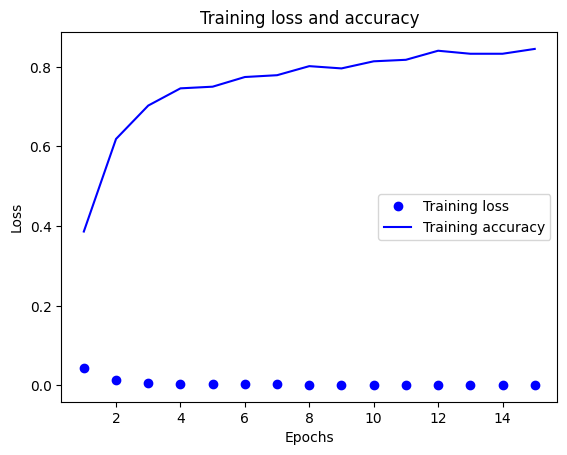

In [124]:
history = net.history
loss = history['loss']
acc = history['accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [125]:
model.evaluate(x_test, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8506 - loss: 0.0042


[0.004224408883601427, 0.8506097793579102]

In [126]:
model.save('model.keras')